# Motif enrichment analysis

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "./scripts")
import functions as f
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


# Yeast Tnet

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
shuffled_matrix = f.get_shuffled_matrix(interaction_matrix, min_swaps=10000)

CPU times: user 31.2 s, sys: 268 ms, total: 31.5 s
Wall time: 31.5 s


In [6]:
print(f"Links before: {interaction_matrix.sum():.0f}\tLinks after: {shuffled_matrix.sum()}")

Links before: 12873	Links after: 12871


In [7]:
print(f"Fraction of original linkfs which moved out: {1-f.corruption_score(interaction_matrix, shuffled_matrix):.2f}")

Fraction of original linkfs which moved out: 0.88


In [13]:
%%time
report = f.get_metrics_report(interaction_matrix)

CPU times: user 1min 24s, sys: 205 ms, total: 1min 24s
Wall time: 1min 24s


In [14]:
%%time
report_shuffled = f.get_metrics_report(shuffled_matrix)

CPU times: user 54.9 s, sys: 68.8 ms, total: 54.9 s
Wall time: 55 s


## Topological measures comparison

Check if there are any differences in degrees

In [15]:
eq = report.degree_seq == report_shuffled.degree_seq
idxs = eq[eq == False].index
report.degree_seq[idxs] - report_shuffled.degree_seq[idxs]

2300    1
2661    1
3221    1
4064    1
dtype: int64

In [16]:
print(f"Average degree \t original: {report.avg_degree:.4f}\tshuffled: {report_shuffled.avg_degree:.4f}")

Average degree 	 original: 5.7973	shuffled: 5.7964


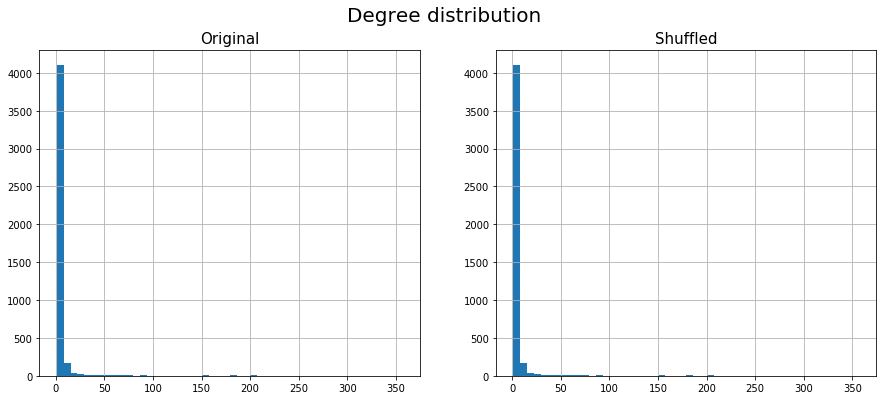

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("Degree distribution", fontsize=20)
ax[0].set_title("Original", fontsize=15); ax[1].set_title("Shuffled", fontsize=15)
report.degree_seq.hist(bins=50, ax=ax[0])
report_shuffled.degree_seq.hist(bins=50, ax=ax[1]);

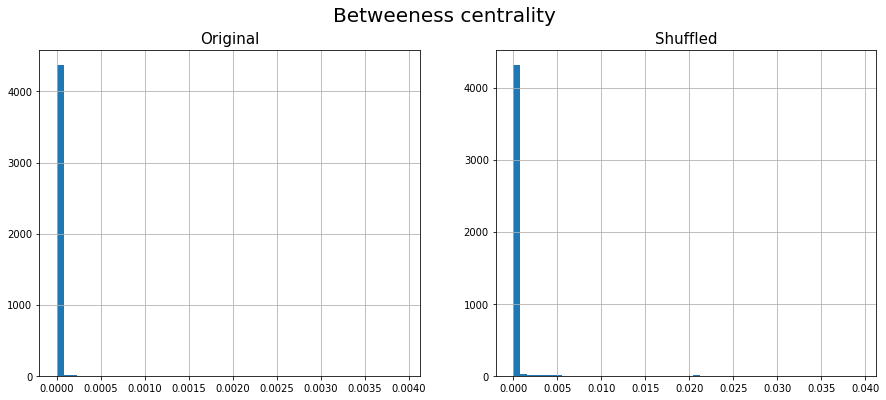

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("Betweeness centrality", fontsize=20)
ax[0].set_title("Original", fontsize=15); ax[1].set_title("Shuffled", fontsize=15)
report.betweenness_centrality.hist(bins=50, ax=ax[0])
report_shuffled.betweenness_centrality.hist(bins=50, ax=ax[1]);

Diameters

In [19]:
print(f"Week conn. diameter \t original: {report.diameter_weak}\tshuffled: {report_shuffled.diameter_weak}")
print(f"Strong conn. diameter \t original: {report.diameter_strong}\tshuffled: {report_shuffled.diameter_strong}")

Week conn. diameter 	 original: 6	shuffled: inf
Strong conn. diameter 	 original: inf	shuffled: inf


Connected part fraction

In [20]:
print(f"The largest strongly connected part fraction \t original: {report.largest_component_frac:.4f}\
\tshuffled: {report_shuffled.largest_component_frac:.4f}")

The largest strongly connected part fraction 	 original: 0.0135	shuffled: 0.4515


## Motifs distribution comparison

In [8]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)

CPU times: user 7.38 s, sys: 221 ms, total: 7.6 s
Wall time: 12.2 s


In [9]:
%%time
motifs_shuffled, counter_shuffled = f.motif_search(cfg, shuffled_matrix, batch_size=10000)

CPU times: user 6.41 s, sys: 193 ms, total: 6.6 s
Wall time: 13.2 s


In [10]:
df1 = pd.DataFrame(columns=["motif", "abundance", "network"])
df1.motif = counter_orig.keys(); df1.abundance = counter_orig.values(); df1.network = "original"
df2 = pd.DataFrame(columns=["motif", "abundance", "network"])
df2.motif = counter_shuffled.keys(); df2.abundance = counter_shuffled.values(); df2.network = "shuffled"
df = pd.concat([df1, df2], axis=0)

In [11]:
df

,motif,abundance,network
0,021C,37631,original
1,021D,1059856,original
2,021U,26042,original
3,030C,8,original
4,030T,3370,original
0,021C,532523,shuffled
1,021D,265491,shuffled
2,021U,265541,shuffled
3,030C,5762,shuffled
4,030T,17780,shuffled


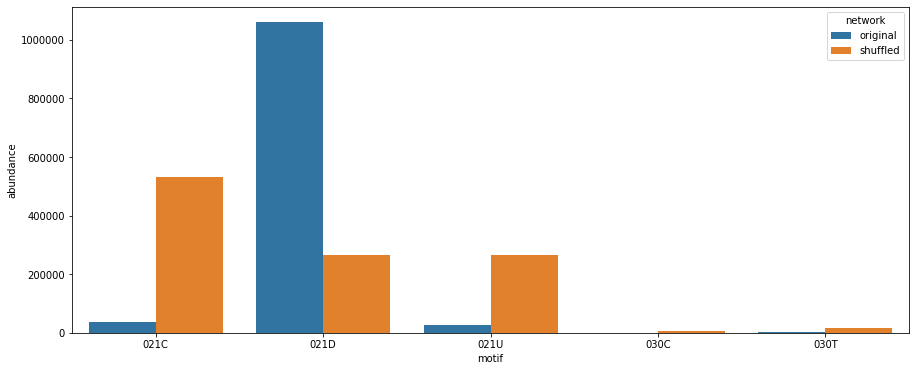

In [12]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x="motif", y="abundance", hue="network");